In [64]:
import pandas as pd
import numpy as np
import torch
import kagglehub
import os
from datasets import load_dataset,Dataset,concatenate_datasets
from collections import Counter
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer,TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,precision_recall_fscore_support
import evaluate
from torch.nn import CrossEntropyLoss

In [65]:
MODEL_NAME = "distilbert-base-uncased"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
metric = evaluate.load("accuracy")

In [66]:
job_list = ['HR', 'designer', 'Information-Technology',
       'Teacher', 'Advocate', 'Business-Development',
       'Healthcare', 'Fitness', 'Agriculture', 'BPO', 'Sales', 'Consultant',
       'Digital-Media', 'Automobile', 'Chef', 'Finance',
       'Apparel', 'Engineering', 'Accountant', 'Construction',
       'Public-Relations', 'Banking', 'Arts', 'Aviation']

label_job_list = {job.lower(): idx for idx, job in enumerate(job_list)}

path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
base_path = os.path.join(path,"Resume")

raw_dataset = load_dataset("csv",data_files=os.path.join(base_path,"Resume.csv"))["train"]
raw_dataset = raw_dataset.map(lambda x: {"Label": label_job_list[x["Category"].lower()]})

full_dataset = Dataset.from_dict({
    "resume_str": list(raw_dataset["Resume_str"]),
    "label": list(raw_dataset["Label"]),
})

full_dataset = full_dataset.shuffle(seed=42)
label_count = Counter(full_dataset["label"])
print(label_count)

max_count = max(label_count.values())
oversampled_datasets = []

for label in label_count.keys():
    class_dataset = full_dataset.filter(lambda x: x["label"] == label)
    repeat_factor = max_count// len(class_dataset) + 1
    oversampled_class_dataset = concatenate_datasets([class_dataset]*repeat_factor)
    oversampled_class_dataset = oversampled_class_dataset.shuffle(seed=42).select(range(max_count))
    oversampled_datasets.append(oversampled_class_dataset)
    
balanced_dataset = concatenate_datasets(oversampled_datasets)
balanced_dataset = balanced_dataset.shuffle(seed=42)
print(Counter(balanced_dataset["label"])) 

Counter({2: 120, 5: 120, 14: 118, 15: 118, 17: 118, 18: 118, 4: 118, 23: 117, 7: 117, 10: 116, 21: 115, 6: 115, 11: 115, 19: 112, 20: 111, 0: 110, 1: 107, 22: 103, 3: 102, 16: 97, 12: 96, 8: 63, 13: 36, 9: 22})


Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2484 [00:00<?, ? examples/s]

Counter({4: 120, 3: 120, 7: 120, 18: 120, 17: 120, 11: 120, 23: 120, 5: 120, 20: 120, 2: 120, 8: 120, 13: 120, 22: 120, 21: 120, 16: 120, 19: 120, 0: 120, 9: 120, 14: 120, 12: 120, 6: 120, 15: 120, 1: 120, 10: 120})


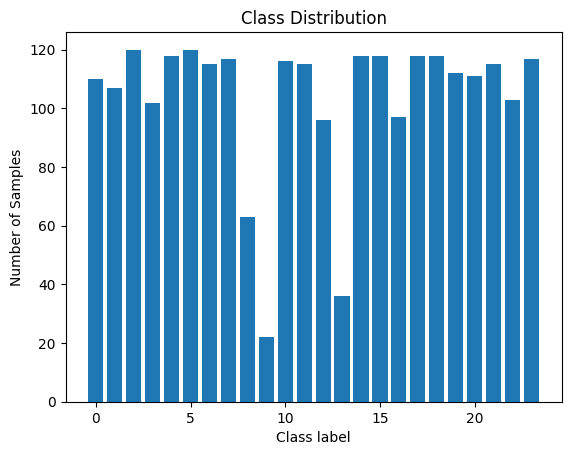

In [67]:
labels, counts = zip(*label_count.most_common())

plt.bar(labels,counts)
plt.xlabel("Class label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

In [68]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["resume_str"], max_length=512, truncation=True,padding="max_length")
    model_inputs["labels"] = examples["label"]
    return model_inputs

n_samples = min(5000, len(full_dataset))
balanced_dataset = Dataset.from_list(list(balanced_dataset.take(n_samples)))

train_test = balanced_dataset.train_test_split(test_size=0.3, seed=42)
valid_test = train_test["test"].train_test_split(test_size=0.5,seed=42)

train_dataset = train_test["train"]
valid_dataset = valid_test["train"]
test_dataset = valid_test["test"]

tokenized_train = train_dataset.map(preprocess_function,batched=True,remove_columns=["resume_str", "label"])
tokenized_valid = valid_dataset.map(preprocess_function,batched=True, remove_columns=["resume_str", "label"])
tokenized_test = test_dataset.map(preprocess_function,batched=True, remove_columns=["resume_str", "label"])

Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

In [69]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=-1)
    
    precision,recall,f1, _ = precision_recall_fscore_support(
        labels, predictions,average="macro",zero_division=0
    )
    
    acc = accuracy_score(labels,predictions)
    
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [70]:
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=24).to(device)
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3

training_args = TrainingArguments(
    output_dir="./results",
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.05,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=100,
)

counts = np.array(list(label_count.values()))
weight = 1.0/counts
weights = weight / weight.sum() * len(counts)
class_weight = torch.tensor(weights, dtype=torch.float).to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self,model,inputs,return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weight)
        loss = loss_fct(logits,labels)
        return (loss,outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Start training ...")
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training ...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.847600,1.824604,0.522788,0.408577,0.439463,0.507173
2,1.518400,0.909016,0.782842,0.755428,0.772691,0.783762
3,0.792500,0.610122,0.871314,0.865959,0.870673,0.874088
4,0.502900,0.537455,0.879357,0.875468,0.879605,0.883577


TrainOutput(global_step=436, training_loss=1.3308139437929205, metrics={'train_runtime': 186.2236, 'train_samples_per_second': 37.331, 'train_steps_per_second': 2.341, 'total_flos': 921274665467904.0, 'train_loss': 1.3308139437929205, 'epoch': 4.0})

In [71]:
test_result = trainer.evaluate(eval_dataset=tokenized_test)
print(f"Test Accuracy: {test_result['eval_accuracy']:.2%}")

Test Accuracy: 87.67%


In [72]:
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids
print("\nDetailed Classification Report:")
print(classification_report(labels, preds, target_names=job_list))


Detailed Classification Report:
                        precision    recall  f1-score   support

                    HR       1.00      1.00      1.00        12
              designer       0.93      1.00      0.96        13
Information-Technology       1.00      0.92      0.96        12
               Teacher       0.90      0.95      0.92        19
              Advocate       0.72      0.81      0.76        16
  Business-Development       1.00      1.00      1.00        17
            Healthcare       1.00      0.83      0.91        12
               Fitness       0.80      0.86      0.83        14
           Agriculture       0.91      0.56      0.69        18
                   BPO       0.83      1.00      0.90        19
                 Sales       0.85      0.92      0.88        12
            Consultant       0.93      1.00      0.97        14
         Digital-Media       0.80      0.86      0.83        14
            Automobile       0.50      0.62      0.55        13
      

In [73]:
trainer.save_model("./final_model")
tokenizer.save_pretrained("./final_model")

('./final_model\\tokenizer_config.json',
 './final_model\\special_tokens_map.json',
 './final_model\\vocab.txt',
 './final_model\\added_tokens.json',
 './final_model\\tokenizer.json')